# Проект "Ранжирование в поиске"

Поиск товаров в онлайн магазине состоит из нескольких этапов. Первый этап по ключевым характеристикам находятся наиболее подходящие кандидаты. Далее отбирается более узкий набор товаров, исходя из наличия на складе, локации и пр. Следующий этап - ранжирование отобранных товаров. Задача состоит в разработке системы оптимизации ранжирования предпоследнего этапа.

**Целью работы** является создание модели и создание Docker образа

Решение состоит из 4 этапов:

1. [Формализации задачи и анализа EDA](#step1)
2. [Проработка вариантов решения](#step2)
3. [Baseline](#step3)
4. [Оптимизация решения](#step4)

В данном блокноте представлен заключительный этап проекта. Оптимизация решения

## Этап 4: оптимизация решения <a class="anchor" id="step4"></a> 

Рассмотрим две модели RankNet и ListNet. Для начала подготовим данные



In [49]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import warnings
import polars as pl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import torch
import datetime
import torch.nn as nn
from itertools import combinations
from scipy.special import expit
from sklearn.metrics import ndcg_score
from typing import List
import math
import torch
import torch.nn as nn
from itertools import combinations
from scipy.special import expit
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import ShuffleSplit

In [3]:
seed=123

In [4]:
df = pl.read_parquet(dist_path)

In [5]:
if 0: #if you need ideal data from original dataset (without Nan)
  df = df.filter(pl.col('feature_2') < 2.4)
  df_q  = df.drop_nulls().groupby('query_id').agg(pl.count('rn')).filter(pl.col('rn') == 100)
  df_q = df_q.join(df, on=['query_id'], how="left")
  df_q = df_q.with_columns(pl.col("target").cast(pl.Int64))
  df_q = df_q.drop('rn')
  df_q = df_q.rename({'rn_right':'rn'})
  df = df_q

In [5]:
df = df.filter(df['feature_2'] < 2.4) #remove outliers

## IterativeImputer

В предыдущем блокноте было показано, что заполнение пропусков не лучшая стратегия. Поэтому заполним данные используя IterativeImputer - sklearn imputer. KNN является предпочтительным, однако требует огромных ресурсов, так 32 ядра при ram 256 при 4 соседях занимает больше часа, поэтому процесс был прерван. Рассмотрим заполнение Баесом и Лесом. Чтобы не переобучить модель и не увеличить сильную корреляцию между признаками ограничимся 15 деревьями и малой глубиной = 10

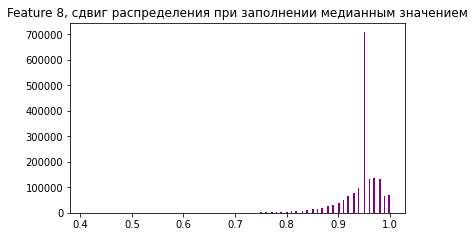

In [77]:
plt.figure(figsize=(6,3.5))
plt.title('Feature 8, сдвиг распределения при заполнении медианным значением')
plt.hist(df['feature_8'].fill_null(pl.median("feature_8")), bins=200, color='purple',)
plt.show()

In [11]:
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=15, max_depth=10, random_state=seed), max_iter=5, random_state=seed)
imputed_data = imputer.fit_transform(df[['feature_5','feature_8','feature_10','feature_7','feature_9','feature_4','feature_1']])

In [6]:
imputerB = IterativeImputer(max_iter=30, random_state=seed)

In [8]:
imputed_dataB = imputerB.fit_transform(df[['feature_5','feature_8','feature_10','feature_7','feature_9','feature_4','feature_1']])

In [ ]:
myImputer_data = pd.DataFrame(imputed_data,columns = ['feature_5','feature_8','feature_10','feature_7','feature_9','feature_4','feature_1'])

In [9]:
myImputer_dataB = pd.DataFrame(imputed_dataB,columns = ['feature_5','feature_8','feature_10','feature_7','feature_9','feature_4','feature_1'])

Рассмотрим полученные распределения, среднее и медиану

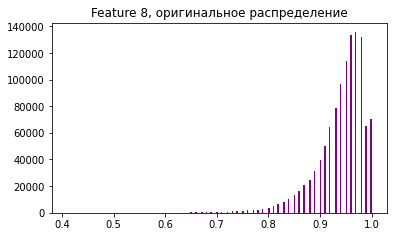

In [76]:
plt.figure(figsize=(6,3.5))
plt.title('Feature 8, оригинальное распределение')
plt.hist(df['feature_8'], bins=200, color='purple',)
plt.show()

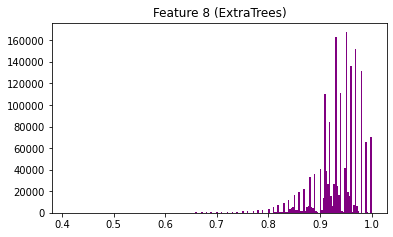

In [70]:
plt.figure(figsize=(6,3.5))
plt.title('Feature 8 (ExtraTrees)')
plt.hist(myImputer_data['feature_8'], bins=200, color='purple',)
plt.show()

In [75]:
print('ExtraTrees')
print('mean - ',myImputer_data['feature_8'].mean())
print('median - ',myImputer_data['feature_8'].median())

ExtraTrees
mean -  0.9350888284876525
median -  0.94


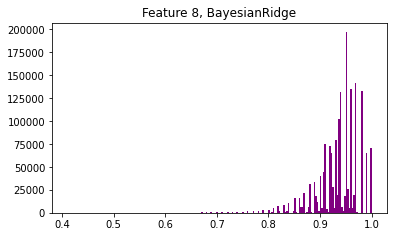

In [68]:
plt.figure(figsize=(6,3.5))
plt.title('Feature 8, BayesianRidge')
plt.hist(myImputer_dataB['feature_8'], bins=200, color='purple',)
plt.show()

In [72]:
print('BayesianRidge')
print('mean - ',myImputer_dataB['feature_8'].mean())
print('median - ',myImputer_dataB['feature_8'].median())

BayesianRidge
mean -  0.9363554951156193
median -  0.94


In [74]:
print('Original')
print(df['feature_8'].mean())
print(df['feature_8'].median())

Original
0.9409674332028577
0.95


**Важное замечание!** Из распределений пропусков признаков 5 и 8, видно, что признак 8 дискретный - 59. У 5 признака дискретность - 3541. Поэтому приведем дискретность 8 признака к такой же оригинальной дискретности. 

ExtraTrees показал более схожее распределение, поэтому он выбран

In [79]:
df['feature_8'].drop_nulls().unique().shape

(59,)

In [80]:
df['feature_5'].drop_nulls().unique().shape

(3541,)

In [10]:
def find_nearest_value(arr, value):
    """Находим ближайшее значение для элемента из array в value."""
    idx = np.abs(arr - value).argmin()
    return arr[idx]

def replace_with_nearest(series1, series2):
    """меняем значения на ближайшее"""
    replaced_values = [find_nearest_value(series2.values, val) for val in series1.values]
    return pd.Series(replaced_values, index=series1.index)

In [11]:
result_series = replace_with_nearest(myImputer_dataB['feature_8'], df['feature_8'].drop_nulls().unique().to_pandas())

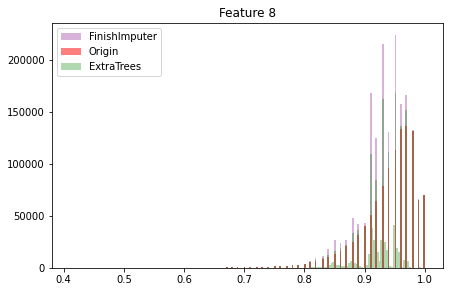

In [89]:
plt.figure(figsize=(7,4.5))
plt.title('Feature 8')
plt.hist(result_series, bins=200, color='purple',alpha=.3,label='FinishImputer')
plt.hist(df['feature_8'], bins=200, color='red',alpha=.5,label='Origin')
plt.hist(myImputer_data['feature_8'], bins=200, color='green',alpha=.3,label='ExtraTrees')
plt.legend()
plt.show()

**Вывод:** полученные данные показавыают смещение. Однако, 30% пустые, поэтому распределение так сильно различается от оригинального

In [12]:
df = df.with_columns(pl.Series('feature_8imp',result_series))
df.tail(15)

query_id,report_date,target,rn,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_8imp
u32,datetime[ns],bool,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
598232,2024-01-28 00:00:00,false,86,0.6945,0.316667,0.383333,0.039878,0.8074,0.0,0.0,null,0.82,4.5,0.412444,0.91
598232,2024-01-28 00:00:00,false,87,0.727,0.066667,0.4,0.451055,0.87,0.0,1.812289,1.0,0.81,4.8,0.078817,1.0
598232,2024-01-28 00:00:00,false,88,0.3625,0.983333,0.345833,0.016081,0.77,0.0,0.0,null,0.81,4.8,0.126572,0.95
598232,2024-01-28 00:00:00,false,89,0.6945,0.266667,0.383333,0.228002,0.87,0.0,0.0,1.0,0.81,4.7,0.154137,1.0
598232,2024-01-28 00:00:00,false,90,0.3625,0.983333,0.345833,0.026205,0.77,0.0,0.0,null,0.8,4.8,0.154854,0.95
598232,2024-01-28 00:00:00,false,91,0.727,0.316667,0.4,0.044012,0.82,0.0,0.0,0.81,0.83,4.8,0.086291,0.81
598232,2024-01-28 00:00:00,false,92,0.702,0.25,0.491667,0.0,0.8074,0.0,0.0,null,0.83,4.8,0.0,0.95
598232,2024-01-28 00:00:00,false,93,0.731,0.116667,0.395833,0.000033,0.87,0.0,0.0,null,0.83,4.6,-0.133599,0.92
598232,2024-01-28 00:00:00,false,94,0.6945,0.266667,0.383333,0.019564,0.87,0.0,0.0,0.92,0.82,4.7,0.08632,0.92


In [13]:
df = df.with_columns(pl.Series('feature_5imp',myImputer_dataB['feature_5']))

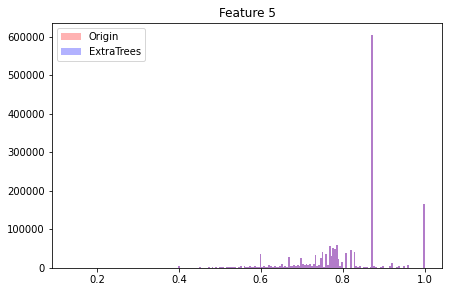

In [118]:
plt.figure(figsize=(7,4.5))
plt.title('Feature 5')
plt.hist(df['feature_5'], bins=200, color='red',alpha=.3,label='Origin')
plt.hist(df['feature_5imp'], bins=200, color='blue',alpha=.3,label='ExtraTrees')
plt.legend()
plt.show()

In [14]:
df = df.drop(['feature_5','feature_8'])

Подготовим данные для обучения

In [15]:
q_train, q_test =  train_test_split(df['query_id'].unique(), test_size=0.3, random_state=seed)
train_df = df.filter(pl.col('query_id').is_in(q_train))
test_df = df.filter(pl.col('query_id').is_in(q_test))
feature_column = df.drop(['report_date','rn','target','query_id']).columns
X_train, X_test = train_df[feature_column].to_numpy(), test_df[feature_column].to_numpy()
y_train, y_test = train_df['target'].to_numpy(), test_df['target'].to_numpy()
queries_train = train_df['query_id'].to_numpy()
queries_test = test_df['query_id'].to_numpy()

## RankNet

Начнем с RankNet

In [54]:
class RankNet(nn.Module):
    def __init__(self, num_input_features, hidden_dim, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.model = nn.Sequential(
            nn.Linear(num_input_features, self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_prob),
            nn.Linear(self.hidden_dim, 1),
        )

    def forward(self, x):
        return self.model(x)


class RankNetTrainer:
    def __init__(self, n_epochs=10, hidden_dim=22, lr=0.001, dropout_prob=0.2):
        self._prepare_data()
        self.num_input_features=self.X_train.shape[1]
        self.n_epochs = n_epochs
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.dropout_prob = dropout_prob
        self.model = self._create_model(
            self.num_input_features, hidden_dim, dropout_prob)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def _create_model(self, num_input_features: int,
                      hidden_dim: int, dropout_prob:float) -> torch.nn.Module:
        torch.manual_seed(123)
        net = RankNet(num_input_features=num_input_features,
                      hidden_dim=hidden_dim, dropout_prob=dropout_prob)
        return net
    
    def predict(self, x):
        
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        
        self.model.eval()
        #
        with torch.no_grad():
            
            predictions = self.model(x)
        return predictions

    def _get_data(self, train_df=train_df, test_df=test_df) -> List[np.ndarray]:
        """
        Полученныe данные преобразуются в  np массив признаков, меток
        и вектор query_id для дальнейшего обучения и теста
        """
        train_df, test_df = train_df, test_df
        feature_column = train_df.drop(['report_date','rn','target','query_id']).columns
        X_train, X_test = train_df[feature_column].to_numpy(), test_df[feature_column].to_numpy()
        y_train, y_test = train_df['target'].to_numpy(), test_df['target'].to_numpy()
        query_ids_train = train_df['query_id'].to_numpy()
        query_ids_test = test_df['query_id'].to_numpy()

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        """
        Функция подготавливает данные для обучения, превращает полученный DataSet
        в FloatTensor.
        """
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()

        X_train = self._scale_features_in_query_groups(
            X_train, self.query_ids_train)
        X_test = self._scale_features_in_query_groups(
            X_test, self.query_ids_test)

        self.X_train = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)

        self.ys_train = torch.FloatTensor(y_train)
        self.ys_test = torch.FloatTensor(y_test)

    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray,
                                        inp_query_ids: np.ndarray) -> np.ndarray:
        """
        Стандартизирует данные для каждого query_id.
        """
        for cur_id in np.unique(inp_query_ids):
            mask = inp_query_ids == cur_id
            tmp_array = inp_feat_array[mask]
            scaler = StandardScaler()
            inp_feat_array[mask] = scaler.fit_transform(tmp_array)

        return inp_feat_array

    def fit(self):

        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(1, self.n_epochs + 1):
            self.model.train()
            print(f"Epoch {epoch}")
            start = datetime.datetime.now()
            for cur_id in np.unique(self.query_ids_train):
                mask_train = self.query_ids_train == cur_id
                batch_X = self.X_train[mask_train]
                batch_ys = self.ys_train[mask_train]

                self.optimizer.zero_grad()
                logits = self.model(batch_X)
                loss = criterion(logits.squeeze(), batch_ys)
                loss.backward()
                self.optimizer.step()
            finish = datetime.datetime.now()
            print('Время исполнения: ' + str(finish - start))


    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray, inp_query_ids: np.ndarray):
        scaler = StandardScaler()
        return scaler.fit_transform(inp_feat_array)

    def evaluate(self, X_test, y_test, query_ids_test, k=10):
        probabilities = self.predict(X_test)
        # Compute NDCG
        ndcg = self._compute_ndcg(probabilities, y_test, query_ids_test, k)
        print(f"NDCG@{k}: {ndcg}")

    def _compute_ndcg(self, probabilities, y_true, query_ids, k):
        ndcg_scores = []
        for qid in np.unique(query_ids):
            mask = (query_ids == qid)
            y_true_qid = y_true[mask]
            proba_qid = probabilities[mask]
            ndcg_qid = ndcg_score(np.expand_dims(y_true_qid, axis=0), np.expand_dims(proba_qid, axis=0), k=k)
            ndcg_scores.append(ndcg_qid)
        return np.mean(ndcg_scores)

    def _eval_test_set(self) -> float:
        with torch.no_grad():
            self.model.eval()
            ndcg_4 = []
            ndcg_8 = []
            ndcg_12 = []
            p_at_1 = []
            p_at_4 = []
            p_at_12 = []
            rr = []
            map_1 = []
            map_4 = []
            map_12 = []
            for cur_id in np.unique(self.query_ids_test):
                mask = self.query_ids_test == cur_id
                X_test_tmp = self.X_test[mask]
                valid_pred = self.model(X_test_tmp)
                test_y = self.ys_test[mask]
                ndcg_score_4 = self._ndcg_k(
                    test_y, valid_pred, 4)
                ndcg_score_8 = self._ndcg_k(
                    test_y, valid_pred, 8)
                ndcg_score_12 = self._ndcg_k(
                    test_y, valid_pred, 12)
                if np.isnan(ndcg_score_4):
                    ndcg_4.append(0)
                    continue
                ndcg_4.append(ndcg_score_4)
                if np.isnan(ndcg_score_8):
                    ndcg_8.append(0)
                    continue
                ndcg_8.append(ndcg_score_8)
                if np.isnan(ndcg_score_12):
                    ndcg_12.append(0)
                    continue
                ndcg_12.append(ndcg_score_12)
                p_at_1.append(self._precission_at_k(
                    test_y, valid_pred))
                p_at_4.append(self._precission_at_k(
                    test_y, valid_pred, k=4))
                p_at_12.append(self._precission_at_k(
                    test_y, valid_pred, k=12))
                rr.append(self._reciprocal_rank(
                    test_y, valid_pred))
                map_1.append(self._average_precision(
                    test_y, valid_pred, 1))
                map_4.append(self._average_precision(
                    test_y, valid_pred, 4))
                map_12.append(self._average_precision(
                    test_y, valid_pred, 12))
            return {
                    'ndcg_4':np.mean(ndcg_4),
                    'ndcg_8':np.mean(ndcg_8),
                    'ndcg_12':np.mean(ndcg_12),
                    'p_at_1':np.mean(p_at_1),
                    'p_at_4':np.mean(p_at_4),
                    'p_at_12':np.mean(p_at_12),
                    'rr':np.mean(rr),
                    'map_at_1':np.mean(map_1),
                    'map_at_4':np.mean(map_4),
                    'map_at_12':np.mean(map_12),
                   }


    def _ndcg_k(self, ys_true, ys_pred, ndcg_top_k) -> float:
        def dcg(ys_true, ys_pred):
            _, argsort = torch.sort(ys_pred, descending=True, dim=0)
            argsort = argsort[:ndcg_top_k]
            ys_true_sorted = ys_true[argsort]
            ret = 0
            for i, l in enumerate(ys_true_sorted, 1):
                ret += (2 ** l - 1) / math.log2(1 + i)
            return ret
        ideal_dcg = dcg(ys_true, ys_true)
        pred_dcg = dcg(ys_true, ys_pred)
        return (pred_dcg / ideal_dcg).item()

    def _precission_at_k(self, ys_true, ys_pred, k=1) -> float:
        if ys_true.sum() == 0:
            return 0
        _, argsort = torch.sort(ys_pred, descending=True, dim=0)
        ys_true_sorted = ys_true[argsort]
        hits = ys_true_sorted[:k].sum()
        prec = hits / min(ys_true.sum(), k)
        return float(prec)


    def _reciprocal_rank(self, ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
        _, argsort = torch.sort(ys_pred, descending=True, dim=0)
        ys_true_sorted = ys_true[argsort]

        for idx, cur_y in enumerate(ys_true_sorted, 1):
            if cur_y == 1:
                return 1 / idx
        return 0


    def _average_precision(self, ys_true: torch.Tensor, ys_pred: torch.Tensor, k=1) -> float:
        if ys_true.sum() == 0:
            return 0
        _, argsort = torch.sort(ys_pred, descending=True, dim=0)
        ys_true_sorted = ys_true[argsort]
        rolling_sum = 0
        num_correct_ans = 0

        for idx, cur_y in enumerate(ys_true_sorted[:k], start=1):
            if cur_y == 1:
                num_correct_ans += 1
                rolling_sum += num_correct_ans / idx
        if num_correct_ans == 0:
            return 0
        else:
            return rolling_sum / num_correct_ans

In [51]:
def custom_cv(n_splits=3, test_size=0.3, seed=seed, df=df, model=None):
    """Cross validation with Nan Imputer"""
    if model == None:
        print('Model is not defined, you lose ;) GAME OVER')
        return None
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=seed)
    metric_cv = []
    unique_list = df['query_id'].unique()
    time_cv = np.array([])
    for i, (train_index, test_index) in enumerate(ss.split(unique_list)):
        print(f'Cross Validation: Fold #{i+1}')
        #Разделяем выборки на тренировочный и валидационный набор
        train_df = df.filter(pl.col('query_id').is_in(unique_list[train_index]))
        test_df = df.filter(pl.col('query_id').is_in(unique_list[test_index]))
        column_list = ['feature_5','feature_8','feature_10','feature_7','feature_9','feature_4','feature_1']
        imputer = IterativeImputer(max_iter=30, random_state=seed) #заменим на Баес для скорости
        imputer.fit(train_df[column_list])
        #Транформация
        imputed_data_train = imputer.transform(train_df[column_list])
        imputed_data_test = imputer.transform(test_df[column_list])
        #Подготовка тренировочной выборки
        myImputer_data = pd.DataFrame(imputed_data_train,columns = column_list)
        result_series = replace_with_nearest(myImputer_data['feature_8'], train_df['feature_8'].drop_nulls().unique().to_pandas())
        train_df = train_df.with_columns(pl.Series('feature_8imp',result_series))
        train_df = train_df.with_columns(pl.Series('feature_5imp',myImputer_data['feature_5']))
        #Подготовка валидационной выборки
        myImputer_data = pd.DataFrame(imputed_data_test,columns = column_list)
        result_series = replace_with_nearest(myImputer_data['feature_8'], train_df['feature_8'].drop_nulls().unique().to_pandas())
        test_df = test_df.with_columns(pl.Series('feature_8imp',result_series))
        test_df = test_df.with_columns(pl.Series('feature_5imp',myImputer_data['feature_5']))

        train_df = train_df.drop(['feature_5','feature_8'])
        test_df = test_df.drop(['feature_5','feature_8'])

        start = datetime.datetime.now()
        model.fit()
        finish = datetime.datetime.now()
        metric_cv.append(model._eval_test_set())
        time_cv = np.append(time_cv, (finish - start))
    metric_cv_average = dict.fromkeys(metric_cv[0], 0)
    for i in metric_cv:
        for j in i.keys():
            metric_cv_average[j] += i[j]
    for j in metric_cv_average.keys():
            metric_cv_average[j] /= n_splits
    df_cv = pd.DataFrame(metric_cv_average,index=[0])
    df_cv['calculation time'] = time_cv.mean()
    return df_cv

In [52]:
def custom_cv_short(n_splits=3, test_size=0.3, seed=seed, df=df, model=None):
    """Cross Validation without Nan Imputer"""
    if model == None:
        print('Model is not defined, you lose ;) GAME OVER')
        return None
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=seed)
    metric_cv = []
    unique_list = df['query_id'].unique()
    time_cv = np.array([])
    for i, (train_index, test_index) in enumerate(ss.split(unique_list)):
        print(f'Cross Validation: Fold #{i+1}')
        #Разделяем выборки на тренировочный и валидационный набор
        train_df = df.filter(pl.col('query_id').is_in(unique_list[train_index]))
        test_df = df.filter(pl.col('query_id').is_in(unique_list[test_index]))
        start = datetime.datetime.now()
        model.fit()
        finish = datetime.datetime.now()
        metric_cv.append(model._eval_test_set())
        time_cv = np.append(time_cv, (finish - start))
    metric_cv_average = dict.fromkeys(metric_cv[0], 0)
    for i in metric_cv:
        for j in i.keys():
            metric_cv_average[j] += i[j]
    for j in metric_cv_average.keys():
            metric_cv_average[j] /= n_splits
    df_cv = pd.DataFrame(metric_cv_average,index=[0])
    df_cv['calculation time'] = time_cv.mean()
    return df_cv

Рассмотрим два гиперпараметра: learning rate, hidden dim. Количество эпох выберем 15, далее, исходя из полученных результатов, рассмотрим влияние количество эпох на лучшую модель. (15 выбрано их опытов на кросс валидации, примерно при этом количестве эпох значения не меняются вплоть до 30 эпох)

In [72]:
table_cv = pd.DataFrame(columns=['lr','hidden_dim','ndcg_4', 'ndcg_8',
                      'ndcg_12', 'p_at_1', 'p_at_4', 'p_at_12',
                      'rr', 'map_at_1', 'map_at_4', 'map_at_12',
                      'calculation time'],index=[0])
for lr in [0.001, 0.005, 0.015]:
    for hidden_dim in [22, 33]:
        print(f'Current model parameters: lr - {lr}, hidden dim - {hidden_dim}')
        print('-------------------------------------')
        ranknet = RankNetTrainer(n_epochs=15, hidden_dim=hidden_dim, lr=lr, dropout_prob=.2)
        ranknet_cv = custom_cv_short(n_splits=3, test_size=0.3, seed=seed, df=df, model=ranknet)
        ranknet_cv['lr'] = lr
        ranknet_cv['hidden_dim'] = hidden_dim
        display(ranknet_cv)
        table_cv = pd.concat([table_cv,ranknet_cv], ignore_index=True)

Current model parameters: lr - 0.001, hidden dim - 22
-------------------------------------
Cross Validation: Fold #1
Epoch 1
Время исполнения: 0:00:44.261167
Epoch 2
Время исполнения: 0:00:44.194673
Epoch 3
Время исполнения: 0:00:44.300120
Epoch 4
Время исполнения: 0:00:44.591951
Epoch 5
Время исполнения: 0:00:44.615648
Epoch 6
Время исполнения: 0:00:44.357514
Epoch 7
Время исполнения: 0:00:44.305484
Epoch 8
Время исполнения: 0:00:44.294346
Epoch 9
Время исполнения: 0:00:44.636662
Epoch 10
Время исполнения: 0:00:43.899044
Epoch 11
Время исполнения: 0:00:43.977417
Epoch 12
Время исполнения: 0:00:44.405962
Epoch 13
Время исполнения: 0:00:43.865787
Epoch 14
Время исполнения: 0:00:43.280161
Epoch 15
Время исполнения: 0:00:42.621479
Cross Validation: Fold #2
Epoch 1
Время исполнения: 0:00:43.843421
Epoch 2
Время исполнения: 0:00:44.125815
Epoch 3
Время исполнения: 0:00:44.403594
Epoch 4
Время исполнения: 0:00:45.367064
Epoch 5
Время исполнения: 0:00:45.193128
Epoch 6
Время исполнения: 0:00

In [75]:
table_cv.drop(0,axis=0)

,lr,hidden_dim,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time
1,0.001,22,0.255360,0.300356,0.327094,0.154388,0.342983,0.560665,0.277314,0.154388,0.231341,0.259217,0 days 00:11:05.436759
2,0.001,33,0.252638,0.298897,0.325120,0.152902,0.338968,0.558275,0.275607,0.152902,0.229135,0.257423,0 days 00:10:57.115775
3,0.005,22,0.249910,0.294443,0.320856,0.151800,0.334049,0.548930,0.273063,0.151800,0.227000,0.254832,0 days 00:11:00.256307
4,0.005,33,0.252309,0.296946,0.323261,0.151800,0.338821,0.553668,0.274459,0.151800,0.228479,0.256209,0 days 00:11:04.658356
5,0.015,22,0.232059,0.279650,0.306610,0.132529,0.317393,0.543135,0.256471,0.132529,0.208645,0.237867,0 days 00:11:05.685582
6,0.015,33,0.250660,0.295486,0.320603,0.152516,0.334228,0.545608,0.274090,0.152516,0.228181,0.255238,0 days 00:11:12.137379


**Вывод:** Модель RankNet результат лучше чем логистическая регрессия. Подбор параметрова на кросс валидации показал, что модель особенно чувствительная к lr. Увеличение к lr привело к падению метрик.

## ListNet

In [76]:
class ListNet(torch.nn.Module):
    """Создаем PyTorch модель для ListNet."""

    def __init__(self, num_input_features, hidden_dim, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_input_features, self.hidden_dim),
            torch.nn.ReLU(),
            nn.Dropout(p=self.dropout_prob),
            torch.nn.Linear(self.hidden_dim, 1)
        )

    def forward(self, input_1):
        logits = self.model(input_1)
        return logits




class ListNetTrain:
    def __init__(self, n_epochs: int = 5, listnet_hidden_dim: int = 30,
                 lr: float = 0.001, ndcg_top_k: int = 10, dropout_prob=.2):
        self._prepare_data() #подготовка данных
        self.num_input_features = self.X_train.shape[1]
        self.ndcg_top_k = ndcg_top_k
        self.n_epochs = n_epochs
        self.dropout_prob = dropout_prob

        self.model = self._create_model(
            self.num_input_features, listnet_hidden_dim, dropout_prob)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def save_model(self, path='listnet_wb.pth'):
        f = open(path, 'wb')
        torch.save(self.model.state_dict, f)

    def load_model(self, path='listnet_lec3.pth'):
        f = open(path, 'rb')
        state_dict = torch.load(f)
        self.model.load_state_dict(state_dict)

    def _get_data(self, train_df=train_df, test_df=test_df) -> List[np.ndarray]:
        """
        Полученныe данные преобразуются в  np массив признаков, меток
        и вектор query_id для дальнейшего обучения и теста
        """
        train_df, test_df = train_df, test_df
        c = train_df.drop(['report_date','rn','target','query_id']).columns
        X_train, X_test = train_df[c].to_numpy(), test_df[c].to_numpy()
        y_train, y_test = train_df['target'].to_numpy(), test_df['target'].to_numpy()
        query_ids_train = train_df['query_id'].to_numpy()
        query_ids_test = test_df['query_id'].to_numpy()

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        """
        Функция подготавливает данные для обучения, превращает полученный DataSet
        в FloatTensor.
        """
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()

        X_train = self._scale_features_in_query_groups(
            X_train, self.query_ids_train)
        X_test = self._scale_features_in_query_groups(
            X_test, self.query_ids_test)

        self.X_train = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)

        self.ys_train = torch.FloatTensor(y_train)
        self.ys_test = torch.FloatTensor(y_test)

    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray,
                                        inp_query_ids: np.ndarray) -> np.ndarray:
        """
        Стандартизирует данные для каждого query_id.
        """
        for cur_id in np.unique(inp_query_ids):
            mask = inp_query_ids == cur_id
            tmp_array = inp_feat_array[mask]
            scaler = StandardScaler()
            inp_feat_array[mask] = scaler.fit_transform(tmp_array)

        return inp_feat_array

    def _create_model(self, listnet_num_input_features: int,
                      listnet_hidden_dim: int, dropout_prob: float) -> torch.nn.Module:
        torch.manual_seed(123)
        net = ListNet(num_input_features=listnet_num_input_features,
                      hidden_dim=listnet_hidden_dim, dropout_prob=dropout_prob)
        return net

    def fit(self) -> List[float]:
        metrics = []
        for epoch_no in range(1, self.n_epochs + 1):
            start = datetime.datetime.now()
            self._train_one_epoch()
            finish = datetime.datetime.now()
            ep_metric = self._eval_test_set()
            metrics.append(ep_metric)
            print(f"Epoch {epoch_no}/{self.n_epochs}")
            print('Время исполнения: ' + str(finish - start))
        return metrics
    
    
    def _train_one_epoch(self):
        """Обучение проходит для каждого запроса. Создаем маску индексов для обучения"""

        self.model.train()
        for cur_id in np.unique(self.query_ids_train):
            mask_train = self.query_ids_train == cur_id
            batch_X = self.X_train[mask_train]
            batch_ys = self.ys_train[mask_train]

            self.optimizer.zero_grad()
            batch_pred = self.model(batch_X).reshape(-1, )
            batch_loss = self._calc_loss(batch_ys, batch_pred)
            batch_loss.backward(retain_graph=True)
            self.optimizer.step()

    def _calc_loss(self, batch_ys: torch.FloatTensor,
                   batch_pred: torch.FloatTensor) -> torch.FloatTensor:
        """Высчитываем функцию потерь"""

        P_y_i = torch.softmax(batch_ys, dim=0)
        P_z_i = torch.softmax(batch_pred, dim=0)
        return -torch.sum(P_y_i * torch.log(P_z_i/P_y_i))



    def _eval_test_set(self) -> float:
        with torch.no_grad():
            self.model.eval()
            ndcg_4 = []
            ndcg_8 = []
            ndcg_12 = []
            p_at_1 = []
            p_at_4 = []
            p_at_12 = []
            rr = []
            map_1 = []
            map_4 = []
            map_12 = []
            for cur_id in np.unique(self.query_ids_test):
                mask = self.query_ids_test == cur_id
                X_test_tmp = self.X_test[mask]
                valid_pred = self.model(X_test_tmp)
                test_y = self.ys_test[mask]
                ndcg_score_4 = self._ndcg_k(
                    test_y, valid_pred, 4)
                ndcg_score_8 = self._ndcg_k(
                    test_y, valid_pred, 8)
                ndcg_score_12 = self._ndcg_k(
                    test_y, valid_pred, 12)
                if np.isnan(ndcg_score_4):
                    ndcg_4.append(0)
                    continue
                ndcg_4.append(ndcg_score_4)
                if np.isnan(ndcg_score_8):
                    ndcg_8.append(0)
                    continue
                ndcg_8.append(ndcg_score_8)
                if np.isnan(ndcg_score_12):
                    ndcg_12.append(0)
                    continue
                ndcg_12.append(ndcg_score_12)
                p_at_1.append(self._precission_at_k(
                    test_y, valid_pred))
                p_at_4.append(self._precission_at_k(
                    test_y, valid_pred, k=4))
                p_at_12.append(self._precission_at_k(
                    test_y, valid_pred, k=12))
                rr.append(self._reciprocal_rank(
                    test_y, valid_pred))
                map_1.append(self._average_precision(
                    test_y, valid_pred,1))
                map_4.append(self._average_precision(
                    test_y, valid_pred,4))
                map_12.append(self._average_precision(
                    test_y, valid_pred,12))
            return {
                    'ndcg_4':np.mean(ndcg_4),
                    'ndcg_8':np.mean(ndcg_8),
                    'ndcg_12':np.mean(ndcg_12),
                    'p_at_1':np.mean(p_at_1),
                    'p_at_4':np.mean(p_at_4),
                    'p_at_12':np.mean(p_at_12),
                    'rr':np.mean(rr),
                    'map_at_1':np.mean(map_1),
                    'map_at_4':np.mean(map_4),
                    'map_at_12':np.mean(map_12),
                   }


    def _ndcg_k(self, ys_true, ys_pred, ndcg_top_k) -> float:
        def dcg(ys_true, ys_pred):
            _, argsort = torch.sort(ys_pred, descending=True, dim=0)
            argsort = argsort[:ndcg_top_k]
            ys_true_sorted = ys_true[argsort]
            ret = 0
            for i, l in enumerate(ys_true_sorted, 1):
                ret += (2 ** l - 1) / math.log2(1 + i)
            return ret
        ideal_dcg = dcg(ys_true, ys_true)
        pred_dcg = dcg(ys_true, ys_pred)
        return (pred_dcg / ideal_dcg).item()

    def _precission_at_k(self, ys_true, ys_pred, k=1) -> float:
        if ys_true.sum() == 0:
            return 0
        _, argsort = torch.sort(ys_pred, descending=True, dim=0)
        ys_true_sorted = ys_true[argsort]
        hits = ys_true_sorted[:k].sum()
        prec = hits / min(ys_true.sum(), k)
        return float(prec)


    def _reciprocal_rank(self, ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
        _, argsort = torch.sort(ys_pred, descending=True, dim=0)
        ys_true_sorted = ys_true[argsort]

        for idx, cur_y in enumerate(ys_true_sorted, 1):
            if cur_y == 1:
                return 1 / idx
        return 0


    def _average_precision(self, ys_true: torch.Tensor, ys_pred: torch.Tensor, k=1) -> float:
        if ys_true.sum() == 0:
            return 0
        _, argsort = torch.sort(ys_pred, descending=True, dim=0)
        ys_true_sorted = ys_true[argsort]
        rolling_sum = 0
        num_correct_ans = 0

        for idx, cur_y in enumerate(ys_true_sorted[:k], start=1):
            if cur_y == 1:
                num_correct_ans += 1
                rolling_sum += num_correct_ans / idx
        if num_correct_ans == 0:
            return 0
        else:
            return rolling_sum / num_correct_ans
        
    def feature_importance(self):
        self.model.eval()
        feature_importance = {}
        with torch.no_grad():
            # Iterate through each layer in the model
            for layer in self.model.model:
                # Check if the layer is a linear layer
                if isinstance(layer, torch.nn.Linear):
                    # Retrieve the weights of the linear layer
                    weights = layer.weight.data.numpy().flatten()  # Flatten the weights
                    norm_weights = abs(weights) / abs(weights).sum()  # Normalize the weights across features
                    for idx, feat in enumerate(df.drop(['report_date','rn','target','query_id']).columns):
                        # Calculate the importance as the normalized weight for each feature
                        if feat in feature_importance:
                            feature_importance[feat] += norm_weights[idx]
                        else:
                            feature_importance[feat] = norm_weights[idx]
        return feature_importance

Рассмотрим как ведет себя модель при разных параметрах обучения

In [ ]:
table_cv_listnet = pd.DataFrame(columns=['lr','hidden_dim','ndcg_4', 'ndcg_8',
                      'ndcg_12', 'p_at_1', 'p_at_4', 'p_at_12',
                      'rr', 'map_at_1', 'map_at_4', 'map_at_12',
                      'calculation time'],index=[0])
for lr in [0.0005, 0.001, 0.01]:
    for hidden_dim in [22, 33]:
        print(f'Current model parameters: lr - {lr}, hidden dim - {hidden_dim}')
        print('-------------------------------------')
        listnet = ListNetTrain(n_epochs=15, listnet_hidden_dim=hidden_dim, lr=lr, dropout_prob=.1)
        listnet_cv = custom_cv_short(n_splits=3, test_size=0.3, seed=seed, df=df, model=listnet)
        listnet_cv['lr'] = lr
        listnet_cv['hidden_dim'] = hidden_dim
        display(listnet_cv)
        table_cv_listnet = pd.concat([table_cv_listnet,listnet_cv], ignore_index=True)

Current model parameters: lr - 0.0005, hidden dim - 22
-------------------------------------
Cross Validation: Fold #1
Epoch 1/15
Время исполнения: 0:00:44.408530
Epoch 2/15
Время исполнения: 0:00:44.414762
Epoch 3/15
Время исполнения: 0:00:44.514919
Epoch 4/15
Время исполнения: 0:00:44.664823
Epoch 5/15
Время исполнения: 0:00:44.686195
Epoch 6/15
Время исполнения: 0:00:44.474483
Epoch 7/15
Время исполнения: 0:00:45.105099
Epoch 8/15
Время исполнения: 0:00:45.383420
Epoch 9/15
Время исполнения: 0:00:45.165771
Epoch 10/15
Время исполнения: 0:00:44.707759
Epoch 11/15
Время исполнения: 0:00:44.388845
Epoch 12/15
Время исполнения: 0:00:45.702384
Epoch 13/15
Время исполнения: 0:00:45.489137
Epoch 14/15
Время исполнения: 0:00:44.772000
Epoch 15/15
Время исполнения: 0:00:45.159445
Cross Validation: Fold #2
Epoch 1/15
Время исполнения: 0:00:45.206678
Epoch 2/15
Время исполнения: 0:00:44.769772
Epoch 3/15
Время исполнения: 0:00:44.502450
Epoch 4/15
Время исполнения: 0:00:45.105260
Epoch 5/15
Вр

,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time,lr,hidden_dim
0,0.26002,0.308742,0.335424,0.157031,0.348434,0.576925,0.282778,0.157031,0.235762,0.265041,0 days 00:15:47.872891,0.0005,22


Current model parameters: lr - 0.0005, hidden dim - 33
-------------------------------------
Cross Validation: Fold #1
Epoch 1/15
Время исполнения: 0:00:45.486833
Epoch 2/15
Время исполнения: 0:00:45.076668
Epoch 3/15
Время исполнения: 0:00:45.559027
Epoch 4/15
Время исполнения: 0:00:45.770536
Epoch 5/15
Время исполнения: 0:00:45.632711
Epoch 6/15
Время исполнения: 0:00:44.424593
Epoch 7/15
Время исполнения: 0:00:44.383307
Epoch 8/15
Время исполнения: 0:00:44.551350
Epoch 9/15
Время исполнения: 0:00:44.643315
Epoch 10/15
Время исполнения: 0:00:44.643882
Epoch 11/15
Время исполнения: 0:00:44.589235
Epoch 12/15
Время исполнения: 0:00:44.839199
Epoch 13/15
Время исполнения: 0:00:44.937035
Epoch 14/15
Время исполнения: 0:00:44.961044
Epoch 15/15
Время исполнения: 0:00:45.119236
Cross Validation: Fold #2
Epoch 1/15
Время исполнения: 0:00:44.893491
Epoch 2/15
Время исполнения: 0:00:45.067509
Epoch 3/15
Время исполнения: 0:00:45.104983
Epoch 4/15
Время исполнения: 0:00:45.386997
Epoch 5/15
Вр

,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time,lr,hidden_dim
0,0.259892,0.308798,0.334994,0.158132,0.34752,0.574697,0.283185,0.158132,0.236091,0.265211,0 days 00:16:01.208038,0.0005,33


Current model parameters: lr - 0.001, hidden dim - 22
-------------------------------------
Cross Validation: Fold #1
Epoch 1/15
Время исполнения: 0:00:45.318784
Epoch 2/15
Время исполнения: 0:00:45.880910
Epoch 3/15
Время исполнения: 0:00:45.633843
Epoch 4/15
Время исполнения: 0:00:45.521205
Epoch 5/15
Время исполнения: 0:00:46.199828
Epoch 6/15
Время исполнения: 0:00:45.461487
Epoch 7/15
Время исполнения: 0:00:46.271718
Epoch 8/15
Время исполнения: 0:00:46.539763
Epoch 9/15
Время исполнения: 0:00:46.497277
Epoch 10/15
Время исполнения: 0:00:46.399079
Epoch 11/15
Время исполнения: 0:00:47.437200
Epoch 12/15
Время исполнения: 0:00:47.452485
Epoch 13/15
Время исполнения: 0:00:47.066876
Epoch 14/15
Время исполнения: 0:00:47.383688
Epoch 15/15
Время исполнения: 0:00:46.245037
Cross Validation: Fold #2
Epoch 1/15
Время исполнения: 0:00:46.779694
Epoch 2/15
Время исполнения: 0:00:46.892968
Epoch 3/15
Время исполнения: 0:00:46.828993
Epoch 4/15
Время исполнения: 0:00:46.916201
Epoch 5/15
Вре

,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time,lr,hidden_dim
0,0.259117,0.308641,0.334359,0.157031,0.346896,0.574223,0.282173,0.157031,0.234959,0.264456,0 days 00:15:59.267406,0.001,22


Current model parameters: lr - 0.001, hidden dim - 33
-------------------------------------
Cross Validation: Fold #1
Epoch 1/15
Время исполнения: 0:00:44.293529
Epoch 2/15
Время исполнения: 0:00:43.992051
Epoch 3/15
Время исполнения: 0:00:44.292067
Epoch 4/15
Время исполнения: 0:00:44.136745
Epoch 5/15
Время исполнения: 0:00:44.375804
Epoch 6/15
Время исполнения: 0:00:44.135457
Epoch 7/15
Время исполнения: 0:00:43.878304
Epoch 8/15
Время исполнения: 0:00:44.341055
Epoch 9/15
Время исполнения: 0:00:44.072618
Epoch 10/15
Время исполнения: 0:00:43.932601
Epoch 11/15
Время исполнения: 0:00:43.647534
Epoch 12/15
Время исполнения: 0:00:44.281528
Epoch 13/15
Время исполнения: 0:00:43.990909
Epoch 14/15
Время исполнения: 0:00:44.056608
Epoch 15/15
Время исполнения: 0:00:44.362120
Cross Validation: Fold #2
Epoch 1/15
Время исполнения: 0:00:44.477453
Epoch 2/15
Время исполнения: 0:00:44.391158
Epoch 3/15
Время исполнения: 0:00:44.142376
Epoch 4/15
Время исполнения: 0:00:44.162690
Epoch 5/15
Вре

,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time,lr,hidden_dim
0,0.260125,0.309891,0.335882,0.157362,0.347704,0.576448,0.283376,0.157362,0.23607,0.265574,0 days 00:15:34.388594,0.001,33


Current model parameters: lr - 0.01, hidden dim - 22
-------------------------------------
Cross Validation: Fold #1
Epoch 1/15
Время исполнения: 0:00:44.224306
Epoch 2/15
Время исполнения: 0:00:43.633175
Epoch 3/15
Время исполнения: 0:00:44.198352
Epoch 4/15
Время исполнения: 0:00:44.215832
Epoch 5/15
Время исполнения: 0:00:44.456549
Epoch 6/15
Время исполнения: 0:00:43.999373
Epoch 7/15
Время исполнения: 0:00:44.184843
Epoch 8/15
Время исполнения: 0:00:44.335326
Epoch 9/15
Время исполнения: 0:00:43.905517
Epoch 10/15
Время исполнения: 0:00:44.162254
Epoch 11/15
Время исполнения: 0:00:44.057971
Epoch 12/15
Время исполнения: 0:00:44.212785
Epoch 13/15
Время исполнения: 0:00:44.219046
Epoch 14/15
Время исполнения: 0:00:44.050944
Epoch 15/15
Время исполнения: 0:00:44.251682
Cross Validation: Fold #2
Epoch 1/15
Время исполнения: 0:00:44.317510
Epoch 2/15
Время исполнения: 0:00:44.123795
Epoch 3/15
Время исполнения: 0:00:44.313920
Epoch 4/15
Время исполнения: 0:00:44.586059
Epoch 5/15
Врем

,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time,lr,hidden_dim
0,0.25355,0.29614,0.310861,0.151856,0.340064,0.509008,0.26645,0.151856,0.229897,0.253189,0 days 00:15:40.245284,0.01,22


Current model parameters: lr - 0.01, hidden dim - 33
-------------------------------------
Cross Validation: Fold #1
Epoch 1/15
Время исполнения: 0:00:44.606100
Epoch 2/15
Время исполнения: 0:00:44.439357
Epoch 3/15
Время исполнения: 0:00:44.584857
Epoch 4/15
Время исполнения: 0:00:44.646273
Epoch 5/15
Время исполнения: 0:00:44.846490
Epoch 6/15
Время исполнения: 0:00:44.744659
Epoch 7/15
Время исполнения: 0:00:44.488216
Epoch 8/15
Время исполнения: 0:00:44.393642
Epoch 9/15
Время исполнения: 0:00:44.495510
Epoch 10/15
Время исполнения: 0:00:44.416264
Epoch 11/15
Время исполнения: 0:00:44.299777
Epoch 12/15
Время исполнения: 0:00:44.397090
Epoch 13/15
Время исполнения: 0:00:43.855914
Epoch 14/15
Время исполнения: 0:00:44.319465
Epoch 15/15
Время исполнения: 0:00:44.502226
Cross Validation: Fold #2
Epoch 1/15
Время исполнения: 0:00:44.696789
Epoch 2/15
Время исполнения: 0:00:44.515066
Epoch 3/15
Время исполнения: 0:00:44.388400
Epoch 4/15
Время исполнения: 0:00:44.529617
Epoch 5/15
Врем

,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time,lr,hidden_dim
0,0.25411,0.296984,0.310969,0.153067,0.339959,0.506838,0.267301,0.153067,0.231009,0.254057,0 days 00:15:43.196118,0.01,33


In [86]:
table_cv_listnet.drop(0,axis=0)

,lr,hidden_dim,ndcg_4,ndcg_8,ndcg_12,p_at_1,p_at_4,p_at_12,rr,map_at_1,map_at_4,map_at_12,calculation time
1,0.0005,22,0.260020,0.308742,0.335424,0.157031,0.348434,0.576925,0.282778,0.157031,0.235762,0.265041,0 days 00:15:47.872891
2,0.0005,33,0.259892,0.308798,0.334994,0.158132,0.347520,0.574697,0.283185,0.158132,0.236091,0.265211,0 days 00:16:01.208038
3,0.0010,22,0.259117,0.308641,0.334359,0.157031,0.346896,0.574223,0.282173,0.157031,0.234959,0.264456,0 days 00:15:59.267406
4,0.0010,33,0.260125,0.309891,0.335882,0.157362,0.347704,0.576448,0.283376,0.157362,0.236070,0.265574,0 days 00:15:34.388594
5,0.0100,22,0.253550,0.296140,0.310861,0.151856,0.340064,0.509008,0.266450,0.151856,0.229897,0.253189,0 days 00:15:40.245284
6,0.0100,33,0.254110,0.296984,0.310969,0.153067,0.339959,0.506838,0.267301,0.153067,0.231009,0.254057,0 days 00:15:43.196118


**Вывод:** ListNet показал прирост показателей по сравнению с бейзлайном и RankNet, особенно, в точности. Недостатком является время обучения, оно учеличилось в 1,5 раза до 15 минут.

Лучшим сочетанием параметров является hidden_dim = 33 и lr = 0.001. Остановимся на этой моделе

Рассмотрим важность признаков. Так как используется Relu, то под важностью будем рассматривать сумму весов для каждого признака.

In [87]:
feature_importance = listnet.feature_importance()

In [88]:
pd.DataFrame(feature_importance,index=[0])

,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_9,feature_10,feature_11,feature_8imp,feature_5imp
0,0.044984,0.080929,0.008144,0.007735,0.003126,0.014163,0.076655,0.042473,0.041455,0.024689,0.016852


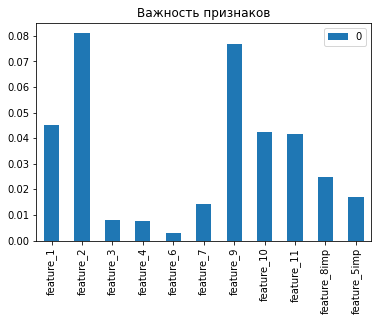

In [89]:
pd.DataFrame(feature_importance,index=[0]).T.plot.bar()
plt.title('Важность признаков')
plt.show()

## Вывод:

В ходе поиска решения  были реализованы на PyTorch и выбраны 2 основных подхода ListNet и RankNet:


Вариация и подбор гиперпараметров показал, что модели подвержены переобучению. Так при не правильном выборе lr и количестве слоев, модели показывали худший вариант чем бейзлайн и наоборот, при 1 эпохе достигали лучшего результата (что, в целом, не ошеломляющая новость).

Модель ListNet показала лучший результат, почти со всеми гиперпараметрами, с помощью кросс валидации были найдены оптимальные гиперпараметры.

Важность признаков следующая для модели ListNet. Как ранее было показано на матрице phi-корреляции,  feature_9 имеет самую высокую корреляцию, что и на таблице важности признаков наблюдается.

In [93]:
pd.DataFrame(feature_importance,index=[0])

,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_9,feature_10,feature_11,feature_8imp,feature_5imp
0,0.044984,0.080929,0.008144,0.007735,0.003126,0.014163,0.076655,0.042473,0.041455,0.024689,0.016852


Лучшее сочетание гиперпараметров следуюшее:

In [92]:
table_cv_listnet.drop(0,axis=0).iloc[3].to_frame()

,4
lr,0.001
hidden_dim,33
ndcg_4,0.260125
ndcg_8,0.309891
ndcg_12,0.335882
p_at_1,0.157362
p_at_4,0.347704
p_at_12,0.576448
rr,0.283376
map_at_1,0.157362
